In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[mujoco]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install gpytorch
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 1s (1,281 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 858.0 kB/s eta 0:00:00
   ━━━━━━

In [15]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import utils
from gymnasium.wrappers import TransformReward, TransformObservation
#from gymnasium.envs.mujoco.inverted_pendulum_v4 import InvertedPendulumEnv
from gymnasium.envs.mujoco.reacher_v4 import ReacherEnv
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box, Discrete
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import torch
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from typing import Tuple

from collections import deque

import pickle

from river import drift

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create Environments

In [4]:
env0 = gym.make("Reacher-v4") ## Training Environment
env1 = gym.make("Reacher-v4") ## Undrifted Production Environment

In [7]:
DEFAULT_CAMERA_CONFIG = {"trackbodyid": 0}

class ReacherEnvDrifted(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(self, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)
        observation_space = Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float64)
        MujocoEnv.__init__(
            self,
            "./reacher_drifted.xml",
            2,
            observation_space=observation_space,
            default_camera_config=DEFAULT_CAMERA_CONFIG,
            **kwargs,
        )

    def step(self, a):
        vec = self.get_body_com("fingertip") - self.get_body_com("target")
        reward_dist = -np.linalg.norm(vec)
        reward_ctrl = -np.square(a).sum()
        reward = reward_dist + reward_ctrl

        self.do_simulation(a, self.frame_skip)
        if self.render_mode == "human":
            self.render()

        ob = self._get_obs()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return (
            ob,
            reward,
            False,
            False,
            dict(reward_dist=reward_dist, reward_ctrl=reward_ctrl),
        )

    def reset_model(self):
        qpos = (
            self.np_random.uniform(low=-0.1, high=0.1, size=self.model.nq)
            + self.init_qpos
        )
        while True:
            self.goal = self.np_random.uniform(low=-0.2, high=0.2, size=2)
            if np.linalg.norm(self.goal) < 0.2:
                break
        qpos[-2:] = self.goal
        qvel = self.init_qvel + self.np_random.uniform(
            low=-0.005, high=0.005, size=self.model.nv
        )
        qvel[-2:] = 0
        self.set_state(qpos, qvel)
        return self._get_obs()

    def _get_obs(self):
        theta = self.data.qpos.flat[:2]
        return np.concatenate(
            [
                np.cos(theta),
                np.sin(theta),
                self.data.qpos.flat[2:],
                self.data.qvel.flat[:2],
                self.get_body_com("fingertip") - self.get_body_com("target"),
            ]
        )



gym.register("ReacherDrifted-v4",
             ReacherEnvDrifted,
             max_episode_steps=50)

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment ReacherDrifted-v4 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [8]:
env2 = gym.make("ReacherDrifted-v4")

## Load Trained RL Model

In [9]:
checkpoint = load_from_hub(
    repo_id = "fatcat22/ppo-reacher-v4",
    filename = "ppo-reacher-v4.zip",
)

model = PPO.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ppo-reacher-v4.zip:   0%|          | 0.00/151k [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Training GP Monitor on Environment 0 (Training Environment)

In [11]:
observations = []
actions = []
rewards = []
dones = []
sources = []
targets = []

obs_t, _ = env0.reset()
observations.append(obs_t)

for i in range(20000):
  action_t, _state = model.predict(obs_t, deterministic=True)
  actions.append(action_t)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  done = terminated or truncated
  dones.append(done)

  observations.append(obs_tplus1)
  rewards.append(r_tplus1)
  sources.append(np.concatenate([obs_t, action_t]))
  targets.append(obs_tplus1-obs_t)

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env0.reset()

sources = np.array(sources)
targets = np.array(targets)

n_train = int(len(sources)*0.8)

In [12]:
X_train_env0, X_test_env0, y_train_env0, y_test_env0 = sources[:n_train],\
                                                       sources[n_train:],\
                                                       targets[:n_train],\
                                                       targets[n_train:]

scaler = StandardScaler()
scaler.fit(X_train_env0)
X_train_env0_scaled = scaler.transform(X_train_env0)
X_test_env0_scaled = scaler.transform(X_test_env0)

# get the number of tasks (the prediction dimensions)
n_tasks = y_train_env0.shape[-1]

# Compute inducing points
n_inducing = 100
kmeans = KMeans(n_clusters=n_inducing).fit(X_train_env0_scaled)
inducing_points = kmeans.cluster_centers_
inducing_points = torch.from_numpy(inducing_points.astype(np.float32))
inducing_points = torch.concat([inducing_points]*n_tasks, dim=0)
inducing_points = inducing_points.reshape(n_tasks, n_inducing, -1)

X_train_env0_tensor = torch.from_numpy(X_train_env0_scaled).contiguous().to(device).float()
X_test_env0_tensor = torch.from_numpy(X_test_env0_scaled).contiguous().to(device).float()
y_train_env0_tensor = torch.from_numpy(y_train_env0).contiguous().to(device).float()
y_test_env0_tensor = torch.from_numpy(y_test_env0).contiguous().to(device).float()


train_dataset = TensorDataset(X_train_env0_tensor, y_train_env0_tensor)
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_dataset = TensorDataset(X_test_env0_tensor, y_test_env0_tensor)
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=False)

class StatePredictor(ApproximateGP):
  def __init__(self, inducing_points):
    inducing_points = inducing_points
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2),
                                                               batch_shape=torch.Size([n_tasks]))

    variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                                                   VariationalStrategy(self, inducing_points,
                                                       variational_distribution,
                                                       learn_inducing_locations=True),
                                                num_tasks=n_tasks
                                             )

    super(StatePredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                                                                ard_num_dims=X_train_env0_tensor.size(-1)),
                                                    batch_shape = torch.Size([n_tasks])
                                                  )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model_gp_env0 = StatePredictor(inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [16]:
num_epochs = 3000


model_gp_env0 = model_gp_env0.to(device)
likelihood = likelihood.to(device)

model_gp_env0.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {"params": model_gp_env0.parameters()},
    {"params": likelihood.parameters()},
], lr=0.05)

#scheduler = MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)
scheduler = ExponentialLR(optimizer, gamma=1-1e-3)

# loss object: VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                    num_data=y_train_env0_tensor.size(0))


best_loss_test = np.inf
losses_train = []
losses_test = []
#epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in range(num_epochs):
  model_gp_env0.train()
  likelihood.train()
  for _, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    optimizer.zero_grad()
    output = model_gp_env0(x_batch)
    loss = -mll(output, y_batch)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_train.append(loss.item())


  with torch.no_grad():
    model_gp_env0.eval()
    likelihood.eval()
    for _, (x_batch, y_batch) in enumerate(test_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      output = model_gp_env0(x_batch)
      loss = -mll(output, y_batch)
      losses_test.append(loss.item())
  print(f"""Iteration: {i+1}, train loss: {np.mean(losses_train)},
                     test loss: {np.mean(losses_test)}""")

  if np.mean(losses_test) < best_loss_test:
      torch.save(model_gp_env0, "model_gp_env0.pth")
      best_loss_test = np.mean(losses_test)
      print("Best model so far!")

Streaming output truncated to the last 5000 lines.
                     test loss: -31.779705404520392
Best model so far!
Iteration: 1335, train loss: -31.892216139110957,
                     test loss: -31.77984493644943
Best model so far!
Iteration: 1336, train loss: -31.892372849908195,
                     test loss: -31.779984259498335
Best model so far!
Iteration: 1337, train loss: -31.892529326141236,
                     test loss: -31.780123374135794
Best model so far!
Iteration: 1338, train loss: -31.892685569048773,
                     test loss: -31.780262280829106
Best model so far!
Iteration: 1339, train loss: -31.89284157794278,
                     test loss: -31.78040098004416
Best model so far!
Iteration: 1340, train loss: -31.892997354201196,
                     test loss: -31.780539472245458
Best model so far!
Iteration: 1341, train loss: -31.893152897633296,
                     test loss: -31.78067775789612
Best model so far!
Iteration: 1342, train loss: -31.89

## Environment Drift Detection

In [18]:
class StatePredictor(ApproximateGP):
  def __init__(self, inducing_points):
    inducing_points = inducing_points
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2),
                                                               batch_shape=torch.Size([n_tasks]))

    variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                                                   VariationalStrategy(self, inducing_points,
                                                       variational_distribution,
                                                       learn_inducing_locations=True),
                                                num_tasks=n_tasks
                                             )

    super(StatePredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                                                                ard_num_dims=X_train_env0_tensor.size(-1)),
                                                    batch_shape = torch.Size([n_tasks])
                                                  )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Load the scaler
import pickle

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the GP model
model_gp_env0 = torch.load("model_gp_env0.pth")

In [ ]:
with torch.no_grad():

  env1_step = 3000
  env2_step = 3000

  total_step = env1_step + env2_step

  compute_mse_steps = 100
  #mse_compute_buffer = deque([], maxlen=compute_mse_steps)
  obs_true = deque([], maxlen=compute_mse_steps)
  obs_predicted = deque([], maxlen=compute_mse_steps)


  n_past_steps_to_store = 500
  replay_buffer = deque([], maxlen=n_past_steps_to_store)

  #mses = deque([], maxlen=n_past_steps_to_store)
  mses_production = []


  env_current = env1
  obs_t, _ = env_current.reset() # Initialize the environment

  for t in range(1, total_step+1):

    if t%500 == 0:
     print(f"step {t}")

    action_t, _state = model.predict(obs_t, deterministic=True)
    obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
    replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

    x = np.concatenate([obs_t, action_t]).reshape(1,-1)
    x = scaler.transform(x)
    x = torch.from_numpy(x)
    x = x.to(device).float()

    y = obs_tplus1-obs_t

    y_predicted = model_gp_env0(x)



    mses_production.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))


    done = terminated or truncated

    obs_t = obs_tplus1

    if done:
      obs_t, _ = env_current.reset()

    if t==env1_step: ## Environment Drift Happens
      env_current = env2
      obs_t, _ = env_current.reset()

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


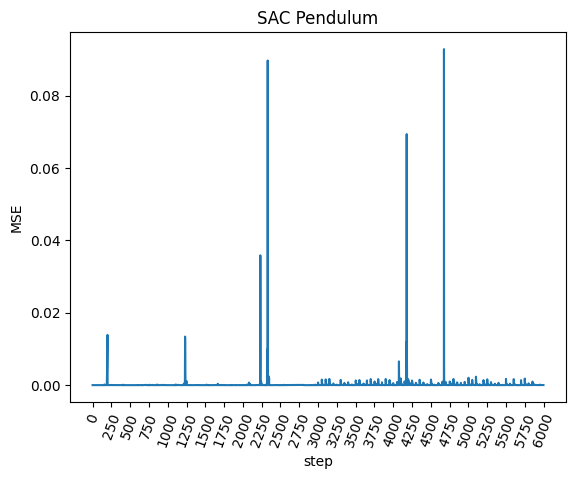

In [ ]:
plt.plot(np.array(mses_production))
#plt.axvline(x=3000, label="Environment Drift", color='red')
plt.xlabel("step")
plt.ylabel("MSE")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.title("SAC Pendulum")
plt.show()

In [ ]:
np.mean(mses_production[:3000])

7.284066270318593e-05

In [ ]:
np.std(mses_production[:3000])

0.002106952359112763

In [ ]:
np.mean(mses_production[3000:])

0.0001714830908889162

In [ ]:
np.std(mses_production[3000:])

0.002894138347590299

### Environment Drift Detection with CUSUM

In [ ]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [ ]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
window_size = 200
mses_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device).float()

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)



  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)
mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref = sigma_ref,
                                   obs_ref=mses_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000

for i,val in enumerate(mses_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="greater")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()
    drift_detector._reset(mses_reference_window)
    if i<3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


### Page-Hinkley

In [ ]:
ph = drift.PageHinkley(mode="up", delta=0.005)

env0_steps = 4000
#window_size = 200
mses_reference = []

obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device).float()

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)



  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  ph.update(val)
  if ph.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 196, input value: 16.156243530044325
Change detected at index 1231, input value: 23.134125634963222
Change detected at index 2232, input value: 62.00003276565879
Change detected at index 2330, input value: 155.2274564162845
Change detected at index 3772, input value: 0.5620197454894915
False Alarms: 4, Delay: 772


### ADWIN

In [ ]:
adwin = drift.ADWIN()

env0_steps = 4000
#window_size = 200
mses_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device).float()

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)

  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


### KSWIN

In [ ]:
kswin = drift.KSWIN()

env0_steps = 4000
mses_reference = []
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device).float()

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)

  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 199, input value: 9.265656634365286
Change detected at index 2347, input value: 0.907522391840883
Change detected at index 3113, input value: 0.012610306405490245
False Alarms: 2, Delay: 113
